In [1]:
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

In [2]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2025-03-06 06:16:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.5MB/s    in 8.3s    

2025-03-06 06:17:03 (19.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [4]:
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback =  tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  return tensorboard_callback

In [5]:

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow as tf


In [7]:
def create_model(model_url,num_classes=10):
  feature_extractor = hub.KerasLayer(model_url,
                                     trainable=False,
                                     name="feature_extractor",
                                     input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model



In [8]:
resnet_model = create_model(resnet_url,num_classes=train_data.num_classes)
resnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (KerasLa  (None, 2048)              23564800  
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [9]:
history_resnet = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tf_hub",experiment_name="resnet50V2")])

Epoch 1/5
24/24 [==============================] - 317s 13s/step - loss: 1.9785 - accuracy: 0.3573 - val_loss: 1.1968 - val_accuracy: 0.6204
Epoch 2/5
24/24 [==============================] - 293s 13s/step - loss: 0.9299 - accuracy: 0.7213 - val_loss: 0.8542 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 291s 13s/step - loss: 0.6463 - accuracy: 0.8053 - val_loss: 0.7438 - val_accuracy: 0.7656
Epoch 4/5
24/24 [==============================] - 302s 13s/step - loss: 0.5031 - accuracy: 0.8640 - val_loss: 0.6972 - val_accuracy: 0.7708
Epoch 5/5
24/24 [==============================] - 306s 13s/step - loss: 0.3983 - accuracy: 0.9013 - val_loss: 0.6847 - val_accuracy: 0.7696


<Axes: >

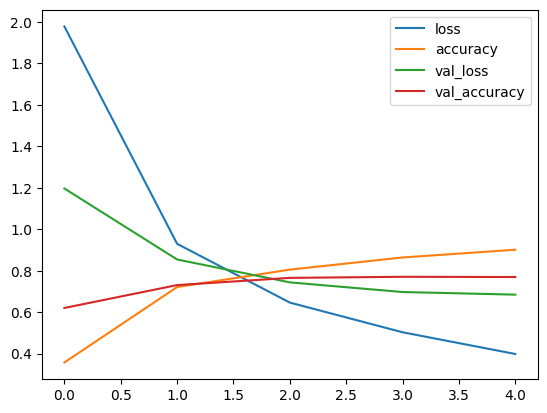

In [11]:
import pandas as pd

pd.DataFrame(history_resnet.history).plot()

In [12]:
efficientnet_model = create_model(efficientnet_url,num_classes=train_data.num_classes)
efficientnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor (KerasLa  (None, 1280)              4049564   
 yer)                                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [15]:
history_efficientnet = efficientnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tf_hub",experiment_name="resnet50V2")])

Epoch 1/5
24/24 [==============================] - 188s 8s/step - loss: 1.8355 - accuracy: 0.4573 - val_loss: 1.2902 - val_accuracy: 0.7360
Epoch 2/5
24/24 [==============================] - 182s 8s/step - loss: 1.0527 - accuracy: 0.7813 - val_loss: 0.8599 - val_accuracy: 0.8256
Epoch 3/5
24/24 [==============================] - 179s 8s/step - loss: 0.7550 - accuracy: 0.8320 - val_loss: 0.6957 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 173s 7s/step - loss: 0.6047 - accuracy: 0.8587 - val_loss: 0.6075 - val_accuracy: 0.8564
Epoch 5/5
24/24 [==============================] - 182s 8s/step - loss: 0.5085 - accuracy: 0.8840 - val_loss: 0.5576 - val_accuracy: 0.8620


<Axes: >

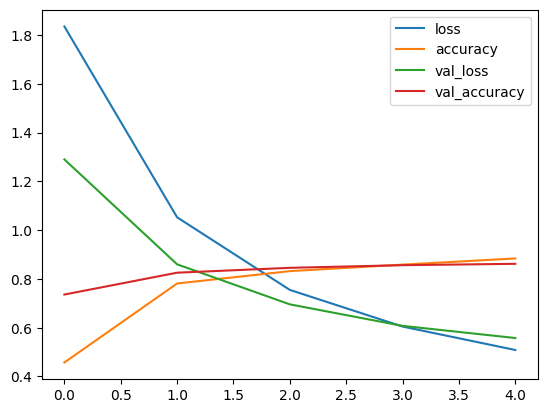

In [16]:
pd.DataFrame(history_efficientnet.history).plot()